## 📌 Objective
The goal of this project is to build a predictive model that identifies which customers are likely to visit a store following an email marketing campaign. By targeting only the most responsive customers, the business aims to improve campaign efficiency, reduce marketing costs, and increase overall conversion rates.

## Table of Contents

1. Understanding the objective
2. Understanding the data
3. Data Preparation
4. Exploratory Analysis
5. Modelling
6. Evaluating the model
7. Deploy the model using Streamlit


### 1. Understanding the objective

Universal Plus (fictional organisation) aims to improve the efficiency of its email marketing campaigns by targeting customers who are most likely to visit the store after receiving an email. Traditionally, marketing emails were sent randomly, leading to low engagement and increased costs.

The goal of this project is to develop a predictive model that identifies which customers are likely to respond positively—i.e., visit the store based on their attributes and past behaviour. This allows for more focused marketing, higher conversion rates, and better ROI.

This project is **not** concerned with customer spend, but only about visits after emails were sent. 

### 2. Understanding the data

#### 📘 Data Dictionary

| Column Name       | Description |
|-------------------|-------------|
| `Customer_ID`     | Unique identifier for each customer |
| `recency`         | Number of days since the customer's last purchase |
| `purchase_segment` | Categorised spending level |
| `purchase`        | Total monetary value of past purchase (£) |
| `mens`            | 1 if the customer bought menswear in the past; 0 otherwise |
| `womens`          | 1 if the customer bought womenswear in the past; 0 otherwise |
| `zip_area`        | Area type (e.g., Rural, Urban, Surburban) based on postal code |
| `new_customer`    | 1 if the customer is new; 0 otherwise |
| `channel`         | Source through which the customer interacts (e.g., Web, Phone) |
| `email_segment`   | Type of email received (e.g., "Mens E-Mail", "Womens E-Mail", or "No E-Mail") |
| `age`             | Age of the customer in years |
| `account`         | 1 if account exists, 0 otherwise |
| `employed`        | 1 if employed; 0 otherwise |
| `phone`           | 1 if phone number is available on record; 0 otherwise |
| `payment_card`    | 1 if payment card is on file; 0 otherwise |
| `spend`           | Amount spent during the latest campaign, £0 implies no purchase |
| `visit`           | **Target variable**: 1 if customer visited the store after receiving email; 0 otherwise |


In [252]:
# install the necessary libraries 
# !pip install pandas
# !pip install scikit-learn
# !pip install seaborn matplotlib
# !pip install imblearn


In [261]:
# import the necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler

import joblib
from IPython.display import IFrame


In [254]:
# read the data
email_data = pd.read_csv('data/email_marketing_data.csv')
df = email_data.copy()
# view a sample of the data
df.head()

,Customer_ID,recency,purchase_segment,purchase,mens,womens,zip_area,new_customer,channel,email_segment,age,account,employed,phone,payment_card,spend,visit
0,11000001,10,2) 100 - 200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,34,1,1,1,1,0.00,0
1,11000002,6,3) 200 - 350,329.08,1,1,Rural,1,Web,No E-Mail,37,1,1,1,0,0.00,0
2,11000003,7,2) 100 - 200,180.65,0,1,Surburban,1,Web,Womens E-Mail,57,1,1,1,0,83.99,1
3,11000004,9,5) 500 - 750,675.83,1,0,Rural,1,Web,Mens E-Mail,37,1,1,1,0,0.00,0
4,11000005,2,1) 0 - 100,45.34,1,0,Urban,0,Web,Womens E-Mail,29,1,1,1,1,0.00,0


After looking at a sample of the data, a few things are clear: 
1. There are some unnecessary columns that are not relevant to the analysis (e.g, Customer_ID, spend)
2. There are columns that need to be cleaned (e.g purchase_segment)
3. There are data for customers who have not been sent an email, which is also not required for this analysis

### 3. Data Preparation & EDA

Before we move over to creating the model, we need to ensure the data is clean and ready for analysis. This includes: 
1. Removing unnecessary columns
2. Filtering out unnecessary records
2. Ensuring columns are of the right data types
3. Addressing null values
4. Check for duplicates

In [255]:
# overview of the data
df.info()

# describe the data
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Customer_ID       64000 non-null  int64  
 1   recency           64000 non-null  int64  
 2   purchase_segment  63974 non-null  object 
 3   purchase          64000 non-null  float64
 4   mens              64000 non-null  int64  
 5   womens            64000 non-null  int64  
 6   zip_area          64000 non-null  object 
 7   new_customer      64000 non-null  int64  
 8   channel           64000 non-null  object 
 9   email_segment     64000 non-null  object 
 10  age               64000 non-null  int64  
 11  account           64000 non-null  int64  
 12  employed          64000 non-null  int64  
 13  phone             64000 non-null  int64  
 14  payment_card      64000 non-null  int64  
 15  spend             63951 non-null  float64
 16  visit             64000 non-null  int64 

,Customer_ID,recency,purchase,mens,womens,new_customer,age,account,employed,phone,payment_card,spend,visit
count,6.400000e+04,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.0,64000.000000,64000.000000,64000.000000,63951.000000,64000.000000
mean,1.103200e+07,5.763734,242.085656,0.550984,0.549703,0.502250,35.343266,1.0,0.998141,0.941594,0.745031,13.877847,0.159078
std,1.847535e+04,3.507592,256.158608,0.497398,0.497527,0.499999,8.925360,0.0,0.043081,0.234512,0.435847,38.496603,0.365752
min,1.100000e+07,1.000000,29.990000,0.000000,0.000000,0.000000,19.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.101600e+07,2.000000,64.660000,0.000000,0.000000,0.000000,28.000000,1.0,1.000000,1.000000,0.000000,0.000000,0.000000
50%,1.103200e+07,6.000000,158.110000,1.000000,1.000000,1.000000,34.000000,1.0,1.000000,1.000000,1.000000,0.000000,0.000000
75%,1.104800e+07,9.000000,325.657500,1.000000,1.000000,1.000000,41.000000,1.0,1.000000,1.000000,1.000000,0.000000,0.000000
max,1.106400e+07,12.000000,3345.930000,1.000000,1.000000,1.000000,62.000000,1.0,1.000000,1.000000,1.000000,499.000000,1.000000


In [256]:
# from this we can see that Customer_ID has all unique values, and account has a single value - we can drop them
# we are also not worried about customer spend, so we can drop that column too
# lack of clarity on "dependent" column, so we will drop it

df = df.drop(["Customer_ID", "account", "spend"], axis = 1)

In [257]:
# we only want to keep the data for customers who have been sent an email
df.email_segment.value_counts()

df = df[df.email_segment != "No E-Mail"].reset_index(drop = True)


In [258]:
# we also have purchase and purchase_segment, both are related so we can drop purchase_segment
df = df.drop(["purchase_segment"], axis = 1)

In [259]:
df.head()

,recency,purchase,mens,womens,zip_area,new_customer,channel,email_segment,age,employed,phone,payment_card,visit
0,10,142.44,1,0,Surburban,0,Phone,Womens E-Mail,34,1,1,1,0
1,7,180.65,0,1,Surburban,1,Web,Womens E-Mail,57,1,1,0,1
2,9,675.83,1,0,Rural,1,Web,Mens E-Mail,37,1,1,0,0
3,2,45.34,1,0,Urban,0,Web,Womens E-Mail,29,1,1,1,0
4,6,134.83,0,1,Surburban,0,Phone,Womens E-Mail,23,1,1,1,1


In [169]:
for col in df.columns:
    print(df[col].value_counts())
    print("\n")


recency
1     6029
10    5081
2     5045
9     4315
3     3968
4     3356
6     3077
5     2993
7     2669
11    2352
8     2331
12    1565
Name: count, dtype: int64


purchase
29.99      5309
45.09         7
72.97         7
41.89         7
64.92         7
           ... 
79.04         1
1530.06       1
1323.32       1
162.65        1
472.82        1
Name: count, Length: 26682, dtype: int64


mens
1    23509
0    19272
Name: count, dtype: int64


womens
1    23569
0    19212
Name: count, dtype: int64


zip_area
Surburban    19182
Urban        17157
Rural         6442
Name: count, dtype: int64


new_customer
1    21482
0    21299
Name: count, dtype: int64


channel
Web             18896
Phone           18727
Multichannel     5158
Name: count, dtype: int64


email_segment
Womens E-Mail    21447
Mens E-Mail      21334
Name: count, dtype: int64


age
29    2227
27    2063
28    1976
30    1948
26    1830
31    1695
25    1657
32    1656
36    1645
33    1639
34    1638
37    1626
35    159

In [170]:
# see if duplicate records exist
df[df.duplicated() == True]

# drop duplicate records
df.drop_duplicates(inplace = True)


In [171]:
# encode the categorical variables
df = pd.get_dummies(df, columns = ["email_segment", "channel", "zip_area"], drop_first = False)


In [172]:
# convert email_segment to int
df["email_segment_Mens E-Mail"] = df["email_segment_Mens E-Mail"].astype(int)
df["email_segment_Womens E-Mail"] = df["email_segment_Womens E-Mail"].astype(int)

# convert channels to int
df["channel_Phone"] = df["channel_Phone"].astype(int)
df["channel_Web"] = df["channel_Web"].astype(int)
df["channel_Multichannel"] = df["channel_Multichannel"].astype(int)

# rename incorrect column name
df.rename(columns = {"zip_area_Surburban": "zip_area_Suburban"}, inplace = True)

# convert zip_area to int
df["zip_area_Rural"] = df["zip_area_Rural"].astype(int)
df["zip_area_Suburban"] = df["zip_area_Suburban"].astype(int)
df["zip_area_Urban"] = df["zip_area_Urban"].astype(int)



In [187]:
# ensure target variable is binary
df["visit"] = df["visit"].astype("category")

visit
0    33557
1     8706
Name: count, dtype: int64

In [251]:
# save the clean data
df.to_csv("data/clean_email_data.csv", index = False)

### 4. Exploratory Data Analysis - carried out in Tableau

### 5. Modelling & Evaluation

Now that we have cleaned the data and encoded the categorical data, we can begin building the model. We will: 
1. Split the independent and dependent variables, 
2. Split the training and testing data
3. Train the model
4. Look at important evaluation metrics - Classification Report, Confusion Matrix
5. Plot ROC and Feature Importance

In [192]:
# target variable value counts
df.visit.value_counts()

# Split the dependent and independent variables
X = df.drop(["visit"], axis = 1)
y = df["visit"]

# Split the training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

# the data is clearly imbalanced, we will use RandomOverSampler to balance the data after splitting the data
ros = RandomOverSampler(random_state = 42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)




#### Logistic Regression

In [193]:
log_reg = LogisticRegression(max_iter = 1000, random_state = 42)
log_reg.fit(X_train_res, y_train_res)

# predict the test data
y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:, 1]

In [194]:
# classification report
class_report = classification_report(y_test, y_pred, output_dict = True)

report_df = pd.DataFrame(class_report).transpose().round(2)

display(report_df)


,precision,recall,f1-score,support
0,0.90,0.65,0.76,6712.00
1,0.35,0.74,0.48,1741.00
accuracy,0.67,0.67,0.67,0.67
macro avg,0.63,0.69,0.62,8453.00
weighted avg,0.79,0.67,0.70,8453.00


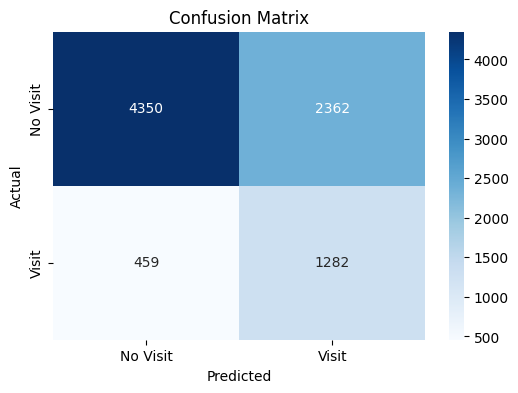

In [195]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Visit', 'Visit'], yticklabels=['No Visit', 'Visit'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [202]:
# plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_proba)

#### Random Forest

In [205]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_res, y_train_res)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

# classification report
class_report_rf = classification_report(y_test, y_pred_rf, output_dict = True)

report_df_rf = pd.DataFrame(class_report_rf).transpose().round(2)

display(report_df_rf)

,precision,recall,f1-score,support
0,0.90,0.94,0.92,6712.00
1,0.72,0.59,0.65,1741.00
accuracy,0.87,0.87,0.87,0.87
macro avg,0.81,0.77,0.78,8453.00
weighted avg,0.86,0.87,0.86,8453.00


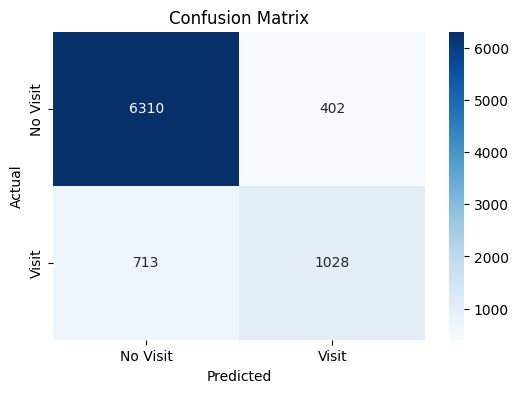

In [ ]:
# confusion matrix for random forest
cm_rf = confusion_matrix(y_test, y_pred_rf)

# plot
plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['No Visit', 'Visit'], yticklabels=['No Visit', 'Visit'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [206]:
# plot ROC curve
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_proba_rf)

# Calculate AUC score
auc_score_rf = roc_auc_score(y_test, y_proba_rf)

#### ROC, AUC, and Feature Importance

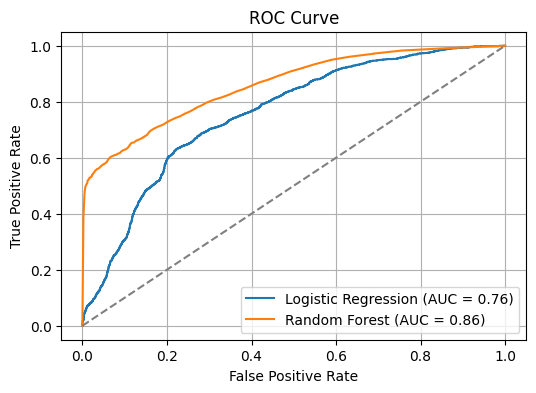

In [207]:
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc_score:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_score_rf:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')  # Diagonal line (random)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

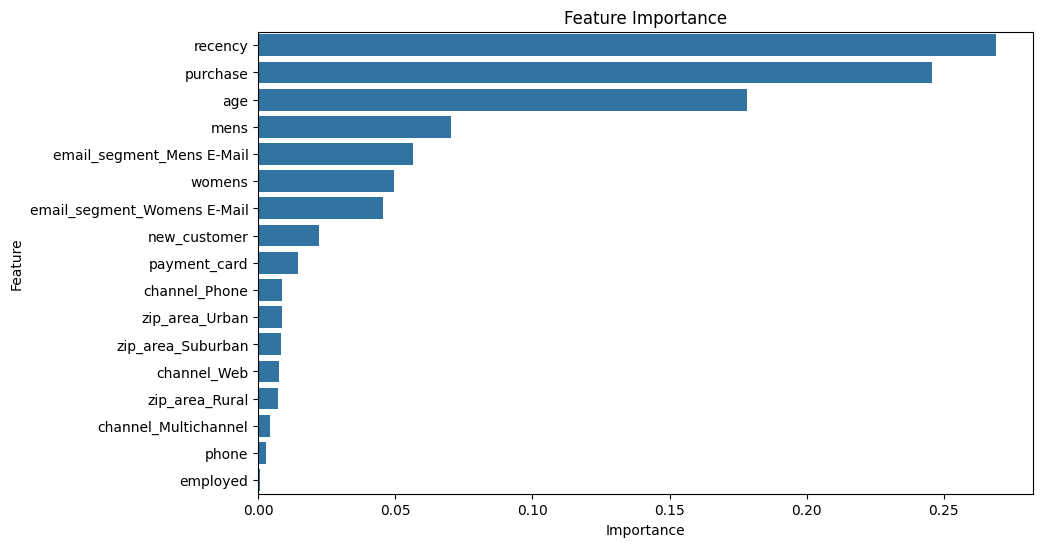

In [ ]:
# Create a DataFrame of features and their importance
importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False).reset_index(drop = True)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances, orient='h')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()



In [220]:
df[['recency', 'purchase', 'mens', 'womens', 'new_customer', 'age',
       'employed', 'phone', 'payment_card', 'email_segment_Mens E-Mail',
       'email_segment_Womens E-Mail', 'channel_Multichannel', 'channel_Phone',
       'channel_Web', 'zip_area_Rural', 'zip_area_Suburban', 'zip_area_Urban', 'visit']].head()

,recency,purchase,mens,womens,new_customer,age,employed,phone,payment_card,email_segment_Mens E-Mail,email_segment_Womens E-Mail,channel_Multichannel,channel_Phone,channel_Web,zip_area_Rural,zip_area_Suburban,zip_area_Urban,visit
0,10,142.44,1,0,0,34,1,1,1,0,1,0,1,0,0,1,0,0
1,7,180.65,0,1,1,57,1,1,0,0,1,0,0,1,0,1,0,1
2,9,675.83,1,0,1,37,1,1,0,1,0,0,0,1,1,0,0,0
3,2,45.34,1,0,0,29,1,1,1,0,1,0,0,1,0,0,1,0
4,6,134.83,0,1,0,23,1,1,1,0,1,0,1,0,0,1,0,1


### 6. Deployment

We will use the `streamlit` package to create a front-end application that users can interact with

In [ ]:
# save the model
joblib.dump(rf, 'random_forest_email_model.pkl')